In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
import mallet
import os, re, nltk

In [2]:
import gensim
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from pprint import pprint
import pickle     

/home/daniel/anaconda3/lib/python3.9/site-packages/gensim/matutils.py:22: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu


In [3]:
#remove stopwords, short tokens, and accents
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
len(stopwords)

[nltk_data] Downloading package stopwords to /home/daniel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


179

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/daniel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
import pickle

In [6]:
path = 'Security_tweets.csv'
df = pd.read_csv(path, low_memory=False)
df.head()

,id,date,content,username,verified,location,followerscount,language,mentions,hashtags,Datecreated,Month,Year,Day,Clean_tweet,Tweet_tokenized,Tweet_lemmatized,Tokens
0,1608523372815683588,2022-12-29 18:00:31+00:00,Code-generating #AI can introduce #security #v...,VeilleCyber3,False,Paris,3193.0,en,NaN,"['AI', 'security', 'vulnerabilities', 'cryptoc...",2022-12-29,12,2022,29,code generating ai introduce security vulnerab...,"['code', 'generating', 'ai', 'introduce', 'sec...","['code', 'generate', 'ai', 'introduce', 'secur...",code generate ai introduce security vulnerabil...
1,1608451577714728960,2022-12-29 13:15:14+00:00,Advanced prompt engineering also needs some ki...,halllo,False,"Karlsruhe, Germany",677.0,en,"[User(username='SGgrc', id=140162079, displayn...","['security', 'ChatGPT']",2022-12-29,12,2022,29,advanced prompt engineering also needs kind se...,"['advanced', 'prompt', 'engineering', 'also', ...","['advanced', 'prompt', 'engineering', 'also', ...",advanced prompt engineering also need kind sec...
2,1608353993629073410,2022-12-29 06:47:28+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrMarchi,False,United States,5815.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",2022-12-29,12,2022,29,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...
3,1608353916726427650,2022-12-29 06:47:10+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrSkanner,False,NY,302.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",2022-12-29,12,2022,29,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...
4,1608194440408989696,2022-12-28 20:13:28+00:00,I’ve been down the chat GPT rabbit hole.. and ...,angelesgomez__,False,NaN,56.0,en,NaN,NaN,2022-12-28,12,2022,28,’ chat gpt rabbit hole ’ fucking scared ’ maki...,"['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...","['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...",chat gpt rabbit hole fucking scar make colleg...


In [7]:
#simple_preprocess: Convert a document into a list of lowercase tokens,
#ignoring tokens that are too short or too long.
df['Token_gensim'] = df['Tweet_lemmatized'].apply(lambda x: [word for word in simple_preprocess(x) \
                                                             if word not in stopwords])

In [8]:
df.head()

,id,date,content,username,verified,location,followerscount,language,mentions,hashtags,Datecreated,Month,Year,Day,Clean_tweet,Tweet_tokenized,Tweet_lemmatized,Tokens,Token_gensim
0,1608523372815683588,2022-12-29 18:00:31+00:00,Code-generating #AI can introduce #security #v...,VeilleCyber3,False,Paris,3193.0,en,NaN,"['AI', 'security', 'vulnerabilities', 'cryptoc...",2022-12-29,12,2022,29,code generating ai introduce security vulnerab...,"['code', 'generating', 'ai', 'introduce', 'sec...","['code', 'generate', 'ai', 'introduce', 'secur...",code generate ai introduce security vulnerabil...,"[code, generate, ai, introduce, security, vuln..."
1,1608451577714728960,2022-12-29 13:15:14+00:00,Advanced prompt engineering also needs some ki...,halllo,False,"Karlsruhe, Germany",677.0,en,"[User(username='SGgrc', id=140162079, displayn...","['security', 'ChatGPT']",2022-12-29,12,2022,29,advanced prompt engineering also needs kind se...,"['advanced', 'prompt', 'engineering', 'also', ...","['advanced', 'prompt', 'engineering', 'also', ...",advanced prompt engineering also need kind sec...,"[advanced, prompt, engineering, also, need, ki..."
2,1608353993629073410,2022-12-29 06:47:28+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrMarchi,False,United States,5815.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",2022-12-29,12,2022,29,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...,"[chatgpt, big, deal, digital, security, ai, ai..."
3,1608353916726427650,2022-12-29 06:47:10+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrSkanner,False,NY,302.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",2022-12-29,12,2022,29,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...,"[chatgpt, big, deal, digital, security, ai, ai..."
4,1608194440408989696,2022-12-28 20:13:28+00:00,I’ve been down the chat GPT rabbit hole.. and ...,angelesgomez__,False,NaN,56.0,en,NaN,NaN,2022-12-28,12,2022,28,’ chat gpt rabbit hole ’ fucking scared ’ maki...,"['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...","['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...",chat gpt rabbit hole fucking scar make colleg...,"[chat, gpt, rabbit, hole, fucking, scar, make,..."


## Create the Bigrams and Trigrams



In [9]:
bigram_obj = Phrases(df['Token_gensim'], min_count=50, threshold=10, delimiter='-')
# #bigram[df['Token']] will apply the bigram object to each row of the df['Token'] column
df['Bigram'] = bigram_obj[df['Token_gensim']]
bigram_model = gensim.models.phrases.Phraser(bigram_obj)

In [10]:
df['Bigram'][300]

['ai',
 'chatbot',
 'wholeworld',
 'flutter',
 'ai',
 'chatgpt',
 'chatbot',
 'robotic',
 'robot',
 'startup',
 'app',
 'intelligence',
 'security',
 'infosec',
 'machinelearning',
 'viral',
 'openai',
 'technology',
 'aichatbot']

In [11]:
trigram_obj = Phrases(df['Bigram'], min_count=50, threshold=10, delimiter='-')
df['Trigram'] = trigram_obj[df['Bigram']]
trigram_model = gensim.models.phrases.Phraser(trigram_obj)

In [12]:
df['Trigram'][20]

['ai',
 'chatgpt',
 'security',
 'chatgpt',
 'threat',
 'tool',
 'artificial-intelligence',
 'ai',
 'potential',
 'bring',
 'many',
 'benefit',
 'human',
 'society',
 'whole',
 'continue',
 'read',
 'medium']

In [13]:
# check for where there is difference between the bigram and the trigram
df[df['Trigram']!=df['Bigram']][0:50]

,id,date,content,username,verified,location,followerscount,language,mentions,hashtags,...,Month,Year,Day,Clean_tweet,Tweet_tokenized,Tweet_lemmatized,Tokens,Token_gensim,Bigram,Trigram
0,1608523372815683588,2022-12-29 18:00:31+00:00,Code-generating #AI can introduce #security #v...,VeilleCyber3,False,Paris,3193.0,en,NaN,"['AI', 'security', 'vulnerabilities', 'cryptoc...",...,12,2022,29,code generating ai introduce security vulnerab...,"['code', 'generating', 'ai', 'introduce', 'sec...","['code', 'generate', 'ai', 'introduce', 'secur...",code generate ai introduce security vulnerabil...,"[code, generate, ai, introduce, security, vuln...","[code, generate, ai, introduce, security, vuln...","[code, generate, ai, introduce, security, vuln..."
19,1607392344579477504,2022-12-26 15:06:13+00:00,How To Use Chat GPT To Make Money Online in 20...,Securitytemple,False,Pagina web oficial,1117.0,en,NaN,"['bugbounty', 'computer', 'cyber', 'ethical', ...",...,12,2022,26,use chat gpt make money online 2023 bugbounty ...,"['use', 'chat', 'gpt', 'make', 'money', 'onlin...","['use', 'chat', 'gpt', 'make', 'money', 'onlin...",use chat gpt make money online 2023 bugbounty ...,"[use, chat, gpt, make, money, online, bugbount...","[use, chat-gpt, make, money, online, bugbounty...","[use, chat-gpt, make, money, online, bugbounty..."
21,1607388591998509059,2022-12-26 14:51:18+00:00,ping Vulnerability Patch Analysis (with #ChatG...,Securitytemple,False,Pagina web oficial,1117.0,en,NaN,"['ChatGPT', 'bugbounty', 'computer', 'cyber', ...",...,12,2022,26,ping vulnerability patch analysis chatgpt cve ...,"['ping', 'vulnerability', 'patch', 'analysis',...","['ping', 'vulnerability', 'patch', 'analysis',...",ping vulnerability patch analysis chatgpt cve ...,"[ping, vulnerability, patch, analysis, chatgpt...","[ping, vulnerability, patch, analysis, chatgpt...","[ping, vulnerability, patch, analysis, chatgpt..."
26,1606750768245395456,2022-12-24 20:36:49+00:00,Top 5 stories of the week: Visions of AI and s...,JackOfAllTechs,False,"Fort Lauderdale, FL",792.0,en,NaN,"['AI', 'AI', 'business', 'ChatGPT']",...,12,2022,24,top 5 stories week visions ai security danced ...,"['top', '5', 'stories', 'week', 'visions', 'ai...","['top', '5', 'story', 'week', 'vision', 'ai', ...",top 5 story week vision ai security dance read...,"[top, story, week, vision, ai, security, dance...","[top-story, week, vision, ai, security, dance,...","[top-story-week, vision, ai, security, dance, ..."
27,1606320089598464001,2022-12-23 16:05:28+00:00,Google is Scared !! - CHAT GPT vs Google https...,Securitytemple,False,Pagina web oficial,1117.0,en,NaN,"['bugbounty', 'computer', 'cyber', 'ethical', ...",...,12,2022,23,google scared chat gpt vs google bugbounty com...,"['google', 'scared', 'chat', 'gpt', 'vs', 'goo...","['google', 'scar', 'chat', 'gpt', 'v', 'google...",google scar chat gpt v google bugbounty comput...,"[google, scar, chat, gpt, google, bugbounty, c...","[google, scar, chat-gpt, google, bugbounty-com...","[google, scar, chat-gpt, google, bugbounty-com..."
28,1606319758726553602,2022-12-23 16:04:09+00:00,How To Make Money With ChatGPT AI (Chat GPT Tu...,Securitytemple,False,Pagina web oficial,1117.0,en,NaN,"['bugbounty', 'computer', 'cyber', 'ethical', ...",...,12,2022,23,make money chatgpt ai chat gpt tutorial bugbou...,"['make', 'money', 'chatgpt', 'ai', 'chat', 'gp...","['make', 'money', 'chatgpt', 'ai', 'chat', 'gp...",make money chatgpt ai chat gpt tutorial bugbou...,"[make, money, chatgpt, ai, chat, gpt, tutorial...","[make, money, chatgpt, ai, chat-gpt, tutorial,...","[make, money, chatgpt, ai, chat-gpt, tutorial,..."
52,1605594820885581824,2022-12-21 16:03:30+00:00,🚨 Reminder: Special Broadcast starts NOW 🚨\n \...,new_2_cyber,False,NaN,2106.0,en,"[User(username='robtlee', id=13867012, display...","['SANSSpecialBroadcast', 'ChatGPT', 'Security']",...,12,2022,21,reminder special broadcast starts tune sansspe...,"['reminder', 'special', 'broadcast', 'starts',...","['reminder',

In [14]:
# Get the bigram and trigram phrases
biphrase = bigram_obj.export_phrases()
triphrase = trigram_obj.export_phrases()
print(f'Bi:{len(biphrase)}, Tri:{len(triphrase)}')

Bi:329, Tri:400


In [15]:
biphrase, triphrase

({'python-deeplearning': 40.19390531799243,
  'deeplearning-daysofcode': 48.65968683838667,
  'daysofcode-fintech': 47.69359094896975,
  'fintech-nocode': 56.199303393420884,
  'nocode-bitcoin': 61.762842679169026,
  'cybersecurite-insurtech': 54.116463914909765,
  'chat-gpt': 32.984569630056555,
  'data-protection': 21.767572004757227,
  'bugbounty-computer': 38.81899560006069,
  'hack-hunt': 10.583130536692979,
  'hunt-infosec': 13.141656215623918,
  'news-pc': 18.437672775314525,
  'pc-pentest': 191.07594647858105,
  'threat-tutorial': 20.590006795665083,
  'artificial-intelligence': 92.69966824101307,
  'cut-edge': 25.968783832551424,
  'natural-language': 76.20997379626597,
  'ciso-cio': 67.03759944849173,
  'cio-cto': 134.06731212057778,
  'top-story': 59.070161386730426,
  'need-know': 14.553529789664035,
  'bot-affect': 36.16280180617233,
  'special-broadcast': 347.85959129861567,
  'audit-amp': 11.749989609063272,
  'phishing-email': 34.17260552428099,
  'reminder-special': 98

In [16]:
# Get the bigram and trigram vocabularies
bigram_vocab = bigram_obj.vocab
trigram_vocab = trigram_obj.vocab

# Sort the bigram and trigram vocabularies by frequency in descending order
sorted_bigram_vocab = sorted(biphrase.items(), key=lambda x: x[1], reverse=True)
sorted_trigram_vocab = sorted(triphrase.items(), key=lambda x: x[1], reverse=True)

# Print the top 20 most common bigrams and trigrams

print("Top 20 most common bigrams:")
for phrase, freq in sorted_bigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))
    

print("\nTop 20 most common trigrams:")
for phrase, freq in sorted_trigram_vocab[:20]:
    print("{}: {}".format(phrase, freq))

Top 20 most common bigrams:
lionel-menchaca: 714.1538279773156
shishir-singh: 684.2995495495496
aaron-mulgrew: 663.1226218787158
wreak-havoc: 612.8418956043955
blogpost-casestudy: 583.7955788768561
devopsdays-austin: 552.1189258312021
anonymous-hacktheplanet: 545.8266160987207
hackernews-hackersnews: 460.9576660632224
edr-xdr: 455.2075298438935
threatintell-cti: 454.4480618466899
datascientists-codenewbies: 429.6089552238806
examines-broad: 394.29863013698633
bredec-reliability: 388.5680721507353
rstats-tensorflow: 357.8233024691358
special-broadcast: 347.85959129861567
mr-xr: 339.3845193508115
roblox-deepweb: 335.6319962686567
comptia-pentest: 286.1817989507531
awareness-threatintell: 275.12531311799603
excite-frighten: 271.36242424242425

Top 20 most common trigrams:
shishir-singh: 2074415.25
aaron-mulgrew: 1128190.75
cybersecurite-insurtech: 193183.34760273973
bell-overtime: 58229.200000000004
nocode-bitcoin: 52586.07998511905
hacktheplanet-news-newsupdate-newsupdates: 42458.7916666

In [17]:
import time
# bi-gram and tri-gram implementation
start_time = time.time()
df['Token_gensim'] = df['Token_gensim'].apply(lambda x:bigram_model[x])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken1: {total_time:.2f} seconds")

start_time = time.time()
df['Token_gensim']= df['Token_gensim'].apply(lambda x:trigram_model[bigram_model[x]])
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken2: {total_time:.2f} seconds")

Total time taken1: 0.52 seconds
Total time taken2: 0.67 seconds


## Lemmatize the Tokens generated using the bigram and trigam models

In [18]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/daniel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/daniel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/daniel/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
#Lemmatization
# nltk.download('wordnet')
# nltk.download('omw-1.4')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

#define a function to map POS tags from treebank tag into wordnet tags
wnl = WordNetLemmatizer()
def get_wordnet(pos):
    if pos.startswith('N'): 
        return wordnet.NOUN
    elif pos.startswith('V'):
        return wordnet.VERB
    elif pos.startswith('J'):
        return wordnet.ADJ
    elif pos.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN     #default to noun if no match

    
# Define a function to tag and lemmatize a text string    
def lemmatizer(text):
    pos_tags = pos_tag(text)
    text = [wnl.lemmatize(word, pos = get_wordnet(pos)) for word, pos in pos_tags]
    return text

start_time = time.time()

df['Lemmatized_gen_token'] = df['Token_gensim'].apply(lambda x: lemmatizer(x))

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 26.50 seconds


In [20]:
# remove stopwords and short tokens again after lemmatization
df['Text_new'] = df['Lemmatized_gen_token'].apply(lambda x: ' '.join(x))
df['Final_Tokens'] = df['Text_new'].apply(lambda x: [word for word in simple_preprocess(x, deacc=True, min_len=3, 
                                                                                  max_len=50) if word not in stopwords])

In [39]:
# import ast
# # # convert the string of words in the 'Tweet_lemmatized' column to a list for each row in the dataframe
# df_new['Tokens'] = df['Final_Tokens'].apply(ast.literal_eval)
# df_new.head()

In [21]:
df.head()

,id,date,content,username,verified,location,followerscount,language,mentions,hashtags,...,Clean_tweet,Tweet_tokenized,Tweet_lemmatized,Tokens,Token_gensim,Bigram,Trigram,Lemmatized_gen_token,Text_new,Final_Tokens
0,1608523372815683588,2022-12-29 18:00:31+00:00,Code-generating #AI can introduce #security #v...,VeilleCyber3,False,Paris,3193.0,en,NaN,"['AI', 'security', 'vulnerabilities', 'cryptoc...",...,code generating ai introduce security vulnerab...,"['code', 'generating', 'ai', 'introduce', 'sec...","['code', 'generate', 'ai', 'introduce', 'secur...",code generate ai introduce security vulnerabil...,"[code, generate, ai, introduce, security, vuln...","[code, generate, ai, introduce, security, vuln...","[code, generate, ai, introduce, security, vuln...","[code, generate, ai, introduce, security, vuln...",code generate ai introduce security vulnerabil...,"[code, generate, introduce, security, vulnerab..."
1,1608451577714728960,2022-12-29 13:15:14+00:00,Advanced prompt engineering also needs some ki...,halllo,False,"Karlsruhe, Germany",677.0,en,"[User(username='SGgrc', id=140162079, displayn...","['security', 'ChatGPT']",...,advanced prompt engineering also needs kind se...,"['advanced', 'prompt', 'engineering', 'also', ...","['advanced', 'prompt', 'engineering', 'also', ...",advanced prompt engineering also need kind sec...,"[advanced, prompt, engineering, also, need, ki...","[advanced, prompt, engineering, also, need, ki...","[advanced, prompt, engineering, also, need, ki...","[advanced, prompt, engineering, also, need, ki...",advanced prompt engineering also need kind sec...,"[advanced, prompt, engineering, also, need, ki..."
2,1608353993629073410,2022-12-29 06:47:28+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrMarchi,False,United States,5815.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",...,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...,"[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...",chatgpt big deal digital security ai ainews ap...,"[chatgpt, big, deal, digital, security, ainews..."
3,1608353916726427650,2022-12-29 06:47:10+00:00,#ChatGPT is a big #Deal and here’s why…\n\n-- ...,MrSkanner,False,NY,302.0,en,NaN,"['ChatGPT', 'Deal', 'Ai', 'AiNews', 'Applicati...",...,chatgpt big deal ’ why… digital security ai ai...,"['chatgpt', 'big', 'deal', 'why', 'digital', '...","['chatgpt', 'big', 'deal', 'why', 'digital', '...",chatgpt big deal why digital security ai ainew...,"[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...","[chatgpt, big, deal, digital, security, ai, ai...",chatgpt big deal digital security ai ainews ap...,"[chatgpt, big, deal, digital, security, ainews..."
4,1608194440408989696,2022-12-28 20:13:28+00:00,I’ve been down the chat GPT rabbit hole.. and ...,angelesgomez__,False,NaN,56.0,en,NaN,NaN,...,’ chat gpt rabbit hole ’ fucking scared ’ maki...,"['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...","['', 'chat', 'gpt', 'rabbit', 'hole', 'fucking...",chat gpt rabbit hole fucking scar make colleg...,"[chat-gpt, rabbit, hole, fucking, scar, make, ...","[chat-gpt, rabbit, hole, fucking, scar, make, ...","[chat-gpt, rabbit, hole, fucking, scar, make, ...","[chat-gpt, rabbit, hole, fuck, scar, make, col...",chat-gpt rabbit hole fuck scar make college jo...,"[chat, gpt, rabbit, hole, fuck, scar, make, co..."


In [22]:
# create dictionary
dictionary = Dictionary(df['Final_Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 17396


In [23]:
corpus = [dictionary.doc2bow(doc) for doc in df['Final_Tokens']]
print(f'Total corpus size: {len(corpus)}')

Total corpus size: 38537


In [24]:
#create a dictionary to show the word and frequency in the corpus
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else: 
            dict_corpus[dictionary[idx]] = freq
df_dict = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])

In [25]:
# Top 10 high-frequency words 
df_dict.sort_values('frequency', ascending = False).head(20)

,frequency
chatgpt,43961
cybersecurity,25235
security,13809
hacker,9618
use,6957
openai,4905
hack,4570
new,4272
malware,4264
data,3728


In [28]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5) 
#words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 3962


In [29]:
corpus = [dictionary.doc2bow(doc) for doc in df['Final_Tokens']]

In [30]:
# Re-check the top words
dict_corpus = {}
for i in range(len(corpus)):
    for idx, freq in corpus[i]:
        if dictionary[idx] in dict_corpus:
            dict_corpus[dictionary[idx]] += freq
        else: 
            dict_corpus[dictionary[idx]] = freq
df_dict_new = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['frequency'])
df_dict_new.sort_values('frequency', ascending = False).head(20)

,frequency
security,13809
hacker,9618
use,6957
openai,4905
hack,4570
new,4272
malware,4264
data,3728
cyber,3683
infosec,3487


In [31]:
# Generate a test corpus
corpus_test = [dictionary.doc2bow(doc) for doc in df['Final_Tokens']]

In [32]:
len(corpus),len(dictionary)

(38537, 3962)

In [18]:
# df_new.to_csv('lammetized_english_tweets.csv', index=False)

In [33]:
import pickle
file_path = 'lammetized_cybersecurity_after_duplicates.pkl'
with open(file_path,'wb') as f:
    pickle.dump(df, f)
print(f"Data saved to '{file_path}' successfully")

Data saved to 'lammetized_cybersecurity_after_duplicates.pkl' successfully


### After the kernel failed, started here

In [4]:
df = pd.read_pickle('lammetized_cybersecurity_after_duplicates.pkl')

In [5]:
# create dictionary
dictionary = Dictionary(df['Final_Tokens'])
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 17396


In [6]:
# Filter extreme words
dictionary.filter_extremes(no_below=10, no_above=0.5) 
#words occur in less than 10 tweets, or more than 50% of tweets
print(f'Total vocabulary size: {len(dictionary)}')

Total vocabulary size: 3962


In [7]:
corpus = [dictionary.doc2bow(doc) for doc in df['Final_Tokens']]

## LDA Implementation

In [8]:
import time
import logging
from tqdm import tqdm

In [9]:
num_topics = 10
passes = 10
total_iteration = num_topics*passes

In [11]:
start_time =time.time()
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# train the LdaModel
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=passes)

end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")

Total time taken: 48.64 seconds


In [37]:
# loading file
import pickle
file = open('lda_model_no_duplicates.pkl','wb')
lda_model = pickle.load(file)
# print(f"Data saved to '{file}' successfully")

Data saved to '<_io.BufferedWriter name='lda_model_no_duplicates.pkl'>' successfully


In [38]:
import pickle
file_path = 'lda_model_no_duplicates.pkl'
with open(file_path,'wb') as f:
    pickle.dump(df, f)
print(f"Data saved to '{file_path}' successfully")

Data saved to 'lda_model_no_duplicates.pkl' successfully


In [40]:
# Display topics
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('amp', 0.030501207),
   ('security', 0.024073588),
   ('new', 0.015028541),
   ('late', 0.014101456),
   ('need', 0.012960109),
   ('generative', 0.010842301),
   ('join', 0.010212686),
   ('world', 0.010104048),
   ('tech', 0.009605481),
   ('trend', 0.00926397)]),
 (1,
  [('machinelearning', 0.072743885),
   ('python', 0.0666343),
   ('deeplearning', 0.059206784),
   ('fintech', 0.057651985),
   ('daysofcode', 0.054694153),
   ('bitcoin', 0.04987045),
   ('insurtech', 0.04587927),
   ('nocode', 0.0455747),
   ('cybersecurite', 0.04471996),
   ('metaverse', 0.020184964)]),
 (2,
  [('openai', 0.025736265),
   ('microsoft', 0.021850187),
   ('security', 0.019681562),
   ('use', 0.019392014),
   ('robotics', 0.017367093),
   ('tool', 0.016794864),
   ('like', 0.015827425),
   ('make', 0.014601565),
   ('employee', 0.010562224),
   ('company', 0.01045053)]),
 (3,
  [('hacker', 0.116704956),
   ('use', 0.07782839),
   ('malware', 0.07196422),
   ('write', 0.032781392),
   ('code',

In [41]:
#Compute Coherence Score
cm = CoherenceModel(model=lda_model, corpus = corpus, coherence='c_v', texts=df['Final_Tokens'])
coherence = cm.get_coherence()

print(f'Coherence score: {coherence}')

Coherence score: 0.4124453117618495


**Coherence score: 0.4124453117618495**

corpus=None,
    num_topics=100,
    id2word=None,
    workers=None,
    chunksize=2000,
    passes=1,
    batch=False,
    alpha='symmetric',
    eta=None,
    decay=0.5,
    offset=1.0,
    eval_every=10,
    iterations=50,
    gamma_threshold=0.001,
    random_state=None,
    minimum_probability=0.01,
    minimum_phi_value=0.01,
    per_word_topics=False,
    dtype=<class 'numpy.float32'>,
)

In [42]:
# To increase the speed, use a multicore Lda model
from gensim.models.ldamulticore import LdaMulticore
start_time =time.time()
#Train the LdaMulticore model
lda_multim_model = LdaMulticore(corpus=corpus, 
                           id2word=dictionary, 
                           num_topics=num_topics, 
                           passes=passes, 
                           workers=10,eval_every=5,iterations=total_iteration)
end_time=time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time:.2f} seconds")


file_path = 'lda_model_MC_no_duplicates.pkl'
with open(file_path,'wb') as f:
    pickle.dump(df, f)
print(f"Data saved to '{file_path}' successfully")

Total time taken: 30.86 seconds
Data saved to 'lda_model_MC_no_duplicates.pkl' successfully


In [43]:
pprint(lda_multim_model.show_topics(formatted=False))

[(0,
  [('security', 0.04369078),
   ('amp', 0.023704138),
   ('like', 0.014142022),
   ('threat', 0.013796176),
   ('risk', 0.013572125),
   ('use', 0.010550206),
   ('cyber', 0.009933488),
   ('new', 0.0076249577),
   ('concern', 0.007217387),
   ('tool', 0.007054889)]),
 (1,
  [('hacker', 0.0466899),
   ('openai', 0.03070863),
   ('use', 0.026115784),
   ('malware', 0.020433014),
   ('security', 0.018400326),
   ('google', 0.013429202),
   ('news', 0.012017755),
   ('create', 0.01111871),
   ('technology', 0.010298298),
   ('new', 0.008683721)]),
 (2,
  [('hack', 0.061766468),
   ('hacker', 0.03607912),
   ('security', 0.029161843),
   ('infosec', 0.027800333),
   ('cyberattack', 0.026245307),
   ('cyber', 0.016241072),
   ('news', 0.015475579),
   ('cloud', 0.013182669),
   ('malware', 0.012702906),
   ('ransomware', 0.011753286)]),
 (3,
  [('data', 0.042175256),
   ('security', 0.03561831),
   ('privacy', 0.031323053),
   ('openai', 0.019586997),
   ('infosec', 0.01380966),
   ('u

In [45]:
# Calculate the coherence score of the multicore model

cm_m = CoherenceModel(model=lda_multim_model, corpus = corpus, coherence='c_v', texts=df['Final_Tokens'])
coherence_m = cm_m.get_coherence()

print(f'Coherence score: {coherence_m}')

Coherence score: 0.34002948498915886


Coherence score for the multicore is less than the single core model. Therefore the single core has better performance which needs to be investigated.**Coherence score: 0.34002948498915886**

## Compute the Optimal Topic

In [12]:
def model_coherence_generator(corpus, dictionary, data, start_topic, end_topic, step, passes, workers):
    models = []
    coherence_scores = []
    for num in tqdm(range(start_topic, end_topic+1, step)):
        ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num, passes=passes, workers=workers)
        cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
        score = cv_coherence_model.get_coherence()
        
        coherence_scores.append(score)
        models.append(ldamodel)
    return models, coherence_scores

In [13]:
#Get the coherence scores by varing the number of topics from 2 to 40 with step=2
lda_models, coherence_scores = model_coherence_generator(corpus, 
                                                         dictionary, 
                                                         df['Final_Tokens'], 
                                                         start_topic=2, 
                                                         end_topic=50, 
                                                         step=2, 
                                                         passes=10, workers=10
                                                        )

100%|███████████████████████████████████████████| 25/25 [12:15<00:00, 29.43s/it]


In [14]:
lda_models

In [15]:
coherence_scores

[0.22802286233096453,
 0.3889407376395224,
 0.40802977619514147,
 0.37489265345732536,
 0.3809586613747463,
 0.383617647273005,
 0.3934001584418665,
 0.3735510422627692,
 0.40260917818602865,
 0.38097857072598296,
 0.41000046831319303,
 0.3760289579224501,
 0.4193897742606976,
 0.3702084507354475,
 0.38409948631180313,
 0.4073576746709425,
 0.3893341468222182,
 0.37942249483420787,
 0.39145121981278946,
 0.3665365620170522,
 0.39385999698482393,
 0.4043771636618665,
 0.37173776242907836,
 0.38571231944799694,
 0.3936354743800262]

In [21]:
coherence_scores[12]

0.4193897742606976

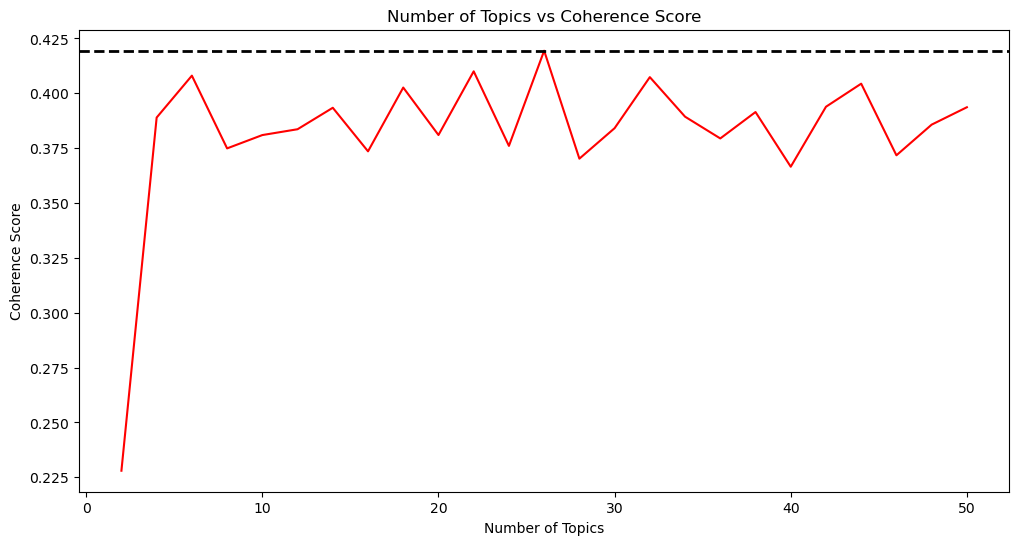

In [22]:
#Plot the number of topics vs coherence score
x_ax = range(2, 51, 2)
y_ax = coherence_scores
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y=0.4194, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Number of Topics vs Coherence Score')
xl = plt.xlabel('Number of Topics')
yl = plt.ylabel('Coherence Score')
plt.show()

In [23]:
coherence_scores[10],coherence_scores[12]

(0.41000046831319303, 0.4193897742606976)

In [24]:
#save the lda_model with 10 topics
lda_10 = lda_models[10]
lda_12=lda_models[12]
# lda_10.save('lda_10')
# lda_18.save('lda_12')

In [25]:
import pickle
#save the model
pickle.dump(lda_10, open('ldamodel_t10.pkl', 'wb'))
pickle.dump(lda_12, open('ldaModel_t12.pkl', 'wb'))

In [98]:
#load model
lda_10 = LdaMulticore.load('lda_10')

In [99]:
vis_data_10 = pyLDAvis.gensim.prepare(lda_10, corpus, dictionary)

In [100]:
vis_data_18 = pyLDAvis.gensim.prepare(lda_18, corpus, dictionary)

In [101]:
pyLDAvis.enable_notebook()

In [102]:
pyLDAvis.display(vis_data_10)

In [103]:
pyLDAvis.display(vis_data_18)

# Varry the iterations to get a more coherent score

In [26]:
#Iterate LdaMulticore model over varing passes
def model_coherence_generator_2(corpus, dictionary, data, passes):
    ldamodel = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=10, passes=passes, workers=10, random_state=42)
    cv_coherence_model = CoherenceModel(model=ldamodel, corpus = corpus, coherence='c_v', texts=data)
    score = cv_coherence_model.get_coherence()
    return ldamodel, score

models = []
coherence_scores = []
for passes in tqdm([1, 5, 10, 20, 40, 60, 80, 100]):
    model, score = model_coherence_generator_2(corpus, dictionary, df['Final_Tokens'], passes)
    models.append(model)
    coherence_scores.append(score)

100%|█████████████████████████████████████████████| 8/8 [11:00<00:00, 82.53s/it]


In [27]:
for m, cv in zip(models, coherence_scores):
    print("Topic Number = ",m, "has coherence value of", round(cv, 4))

Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.2131
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.3548
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.3997
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.4354
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.4517
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.4633
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.4554
Topic Number =  LdaModel(num_terms=3962, num_topics=10, decay=0.5, chunksize=2000) has coherence value of 0.4574


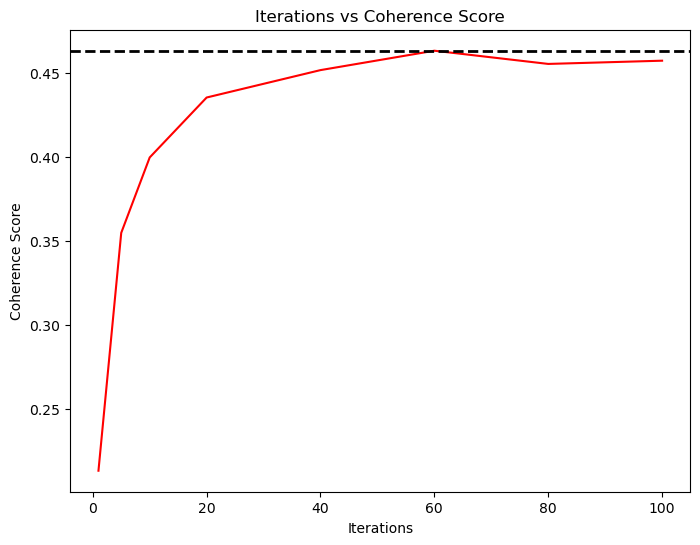

In [29]:
#Plot the iteration times vs coherence score
x_ax = [1, 5, 10, 20, 40, 60, 80, 100]
y_ax = coherence_scores
plt.figure(figsize=(8, 6))
plt.plot(x_ax, y_ax, c='r')
plt.axhline(y= 0.4633, c='k', linestyle='--', linewidth=2)
plt.rcParams['figure.facecolor'] = 'white'
plt.title('Iterations vs Coherence Score')
xl = plt.xlabel('Iterations')
yl = plt.ylabel('Coherence Score')
plt.show()

In [32]:
lda_topic10_passes60 = models[5]
pickle.dump(lda_topic10_passes60, open('ldamodel_t10_p60.pkl', 'wb'))

### We have identified that 10 topics with 60 passes gives the highest coherence score. We will use this to train the final model

In [35]:
#lda_10_60 = LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=12, passes=60, workers=20)
cv_coherence_model = CoherenceModel(model=lda_topic10_passes60, corpus = corpus, coherence='c_v', texts=df["Final_Tokens"])
score = cv_coherence_model.get_coherence()
print(score)

0.46329326991541564


# Topic Identification

In [104]:
#get the topic distribution for each tweets
topic_dist = [lda_topic10_passes60[doc] for doc in corpus]

In [105]:
#get the dominant topic and the score
dominant_topic = [max(topic, key=lambda x:x[1])[0] for topic in topic_dist]
scores =[max(topic, key=lambda x:x[1])[1] for topic in topic_dist]

#Create a dataframe to show dominant topic for each tweet
df_topic = df[['username','content','Final_Tokens','Datecreated']].copy()
df_topic['Dominant_Topic'] = [topic+1 for topic in dominant_topic]
df_topic['Contribution%'] = [round(score*100,2) for score in scores]
df_topic.head()

,username,content,Final_Tokens,Datecreated,Dominant_Topic,Contribution%
0,VeilleCyber3,Code-generating #AI can introduce #security #vulnerabilities \nhttps://t.co/tBoOQkK4LD\n\n#cryptocurrencies #MachineLearning #AI #Python #DeepLearning #100DaysOfCode #fintech #nocode #bitcoin #cybersecurity #cybersecurite #inSurTech #ChatGPT https://t.co/BOjNHVlNQ0,"[code, generate, introduce, security, vulnerability, machinelearning, python, deeplearning, daysofcode, fintech, nocode, bitcoin, cybersecurity, cybersecurite, insurtech, chatgpt]",2022-12-29,7,73.01
1,halllo,Advanced prompt engineering also needs some kind of #security #ChatGPT @SGgrc \nhttps://t.co/euF66Y2KXt,"[advanced, prompt, engineering, also, need, kind, security, chatgpt]",2022-12-29,2,61.36
2,MrMarchi,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/EYOMaiWkn5.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/LsbJxuSUm8,"[chatgpt, big, deal, digital, security, ainews, application, bug, chatbot, chatbots, code, cod, composition, computer, customerservice, cybersecurity]",2022-12-29,6,63.94
3,MrSkanner,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/1mLxQxpvAS.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/vxhMiwJkPq,"[chatgpt, big, deal, digital, security, ainews, application, bug, chatbot, chatbots, code, cod, composition, computer, customerservice, cybersecurity]",2022-12-29,6,63.94
4,angelesgomez__,I’ve been down the chat GPT rabbit hole.. and I’m fucking scared I’m not making it out of college with any job security,"[chat, gpt, rabbit, hole, fuck, scar, make, college, job, security]",2022-12-28,2,54.65


In [106]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Final_Tokens':'count'}).copy().reset_index() #replace final_tokens with tweet
df_topic_summary.rename(columns={'Final_Tokens':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,6,5893,15.29
1,3,5621,14.59
2,2,5217,13.54
3,9,4260,11.05
4,5,3827,9.93
5,10,3550,9.21
6,1,2946,7.64
7,4,2902,7.53
8,7,2686,6.97
9,8,1635,4.24


In [107]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, 
           weight in lda_topic10_passes60.show_topic(n,topn=20)] for n in range(0,lda_topic10_passes60.num_topics)]

In [108]:
topics

[[('security', 0.057),
  ('hack', 0.056),
  ('hacker', 0.041),
  ('technology', 0.033),
  ('cloud', 0.028),
  ('cyberattack', 0.024),
  ('tech', 0.023),
  ('news', 0.023),
  ('new', 0.02),
  ('privacy', 0.02),
  ('infosec', 0.017),
  ('blockchain', 0.016),
  ('cyber', 0.015),
  ('dataprotection', 0.013),
  ('crypto', 0.012),
  ('bigtech', 0.011),
  ('threat', 0.008),
  ('computer', 0.008),
  ('risk', 0.007),
  ('innovation', 0.007)],
 [('security', 0.037),
  ('gpt', 0.026),
  ('openai', 0.017),
  ('microsoft', 0.015),
  ('chat', 0.012),
  ('tool', 0.012),
  ('make', 0.01),
  ('work', 0.009),
  ('use', 0.009),
  ('like', 0.009),
  ('need', 0.009),
  ('new', 0.008),
  ('technology', 0.007),
  ('human', 0.006),
  ('model', 0.006),
  ('automate', 0.006),
  ('come', 0.006),
  ('cyber', 0.005),
  ('base', 0.005),
  ('power', 0.005)],
 [('hacker', 0.056),
  ('use', 0.047),
  ('malware', 0.043),
  ('write', 0.03),
  ('code', 0.019),
  ('phishing', 0.018),
  ('create', 0.018),
  ('malicious', 0

In [109]:
pprint(lda_topic10_passes60.show_topics())

[(0,
  '0.057*"security" + 0.056*"hack" + 0.041*"hacker" + 0.033*"technology" + '
  '0.028*"cloud" + 0.024*"cyberattack" + 0.023*"tech" + 0.023*"news" + '
  '0.020*"new" + 0.020*"privacy"'),
 (1,
  '0.037*"security" + 0.026*"gpt" + 0.017*"openai" + 0.015*"microsoft" + '
  '0.012*"chat" + 0.012*"tool" + 0.010*"make" + 0.009*"work" + 0.009*"use" + '
  '0.009*"like"'),
 (2,
  '0.056*"hacker" + 0.047*"use" + 0.043*"malware" + 0.030*"write" + '
  '0.019*"code" + 0.018*"phishing" + 0.018*"create" + 0.018*"malicious" + '
  '0.012*"exploit" + 0.011*"attack"'),
 (3,
  '0.038*"google" + 0.019*"robotics" + 0.015*"security" + 0.014*"industry" + '
  '0.014*"apple" + 0.014*"openai" + 0.010*"technology" + 0.010*"web" + '
  '0.010*"bard" + 0.009*"seo"'),
 (4,
  '0.078*"hacker" + 0.039*"news" + 0.025*"new" + 0.024*"openai" + '
  '0.018*"story" + 0.013*"security" + 0.013*"top" + 0.012*"use" + '
  '0.010*"vulnerability" + 0.010*"bug"'),
 (5,
  '0.042*"security" + 0.023*"risk" + 0.023*"use" + 0.022*"data"

In [110]:
pprint(lda_model.show_topics())

[(0,
  '0.083*"hacker" + 0.062*"use" + 0.053*"malware" + 0.026*"write" + '
  '0.022*"phishing" + 0.021*"create" + 0.019*"malicious" + 0.017*"code" + '
  '0.016*"tool" + 0.012*"exploit"'),
 (1,
  '0.037*"security" + 0.030*"threat" + 0.022*"amp" + 0.021*"intelligence" + '
  '0.017*"artificial" + 0.013*"learn" + 0.012*"new" + 0.012*"stay" + '
  '0.009*"protect" + 0.009*"digital"'),
 (2,
  '0.070*"deeplearning" + 0.068*"fintech" + 0.068*"python" + '
  '0.066*"machinelearning" + 0.059*"bitcoin" + 0.057*"daysofcode" + '
  '0.054*"insurtech" + 0.054*"nocode" + 0.053*"cybersecurite" + '
  '0.024*"metaverse"'),
 (3,
  '0.069*"news" + 0.058*"hacker" + 0.043*"new" + 0.026*"top" + 0.025*"story" + '
  '0.018*"meta" + 0.012*"put" + 0.011*"web" + 0.011*"show" + '
  '0.009*"jailbreak"'),
 (4,
  '0.044*"security" + 0.022*"cyber" + 0.021*"like" + 0.019*"read" + '
  '0.019*"tool" + 0.018*"article" + 0.018*"warn" + 0.017*"technology" + '
  '0.017*"potential" + 0.017*"late"'),
 (5,
  '0.043*"security" + 0.

In [81]:
# #Summarize the topic names based on each topics' top terms and highly-relevant tweets 
# names = {1:"T1 ChatGPT usage in Hacking and Cyberattacks",
#         2:"T2 Ehancing Company data Security",
#         3:"T3 A tool for malware creation and exploits",
#         4:"T4 Industrial Robotics Application",
#         5:"T5 Vulnerability and Bug hunting tool",
#         6:"T6 Security Risks of ChatGPT usage",
#         7:"T7 ChatGPT Productivity in Coding",
#         8:"T8 Impacts on IoT Security and Bigdata",
# #         9:"T9 Threat Intelligence Gathering and Response",
#         10:"T10 Data Privacy and Security"
#         }


## Exploring the Topics again

In [111]:
#Summarize the topic names based on each topics' top terms and highly-relevant tweets 
names = {1:"1: Cybersecurity issues with ChatGPT",
        2:"2 AI Technologies and Security",
        3:"3 Hacking Techniques and Cybersecurity Threats",
        4:"4 Technology Trends, SEO and Robotics",
        5:"5 Hacking News and Security Vulnerabilities",
        6:"6 Data Security and Risk Management",
        7:"7 Fintech and Emerging Technologies",
        8:"8 Data Science, IoT Security and Bigdata",
        9:"9 Threat Intelligence Gathering and Response",
        10:"10 Data Privacy and Information Security"
        }

In [113]:
df_topic['Topic_Name'] = df_topic['Dominant_Topic'].map(names)

In [112]:
pd.set_option('display.max_colwidth', None)
topic_df = pd.DataFrame({'Topic_Name':names.values(), 
                         'Topic_Terms':[','.join([term for term, weight in topic]) for topic in topics]},
                        index = ['Topic ' + str(n) for n in range(1,lda_topic10_passes60.num_topics+1)])
# apply style to align content to the left
topic_df

,Topic_Name,Topic_Terms
Topic 1,1: Cybersecurity issues with ChatGPT,"security,hack,hacker,technology,cloud,cyberattack,tech,news,new,privacy,infosec,blockchain,cyber,dataprotection,crypto,bigtech,threat,computer,risk,innovation"
Topic 2,2 AI Technologies and Security,"security,gpt,openai,microsoft,chat,tool,make,work,use,like,need,new,technology,human,model,automate,come,cyber,base,power"
Topic 3,3 Hacking Techniques and Cybersecurity Threats,"hacker,use,malware,write,code,phishing,create,malicious,exploit,attack,tool,warn,email,could,via,chatbot,cybercriminals,get,security,scam"
Topic 4,"4 Technology Trends, SEO and Robotics","google,robotics,security,industry,apple,openai,technology,web,bard,seo,search,hacker,week,may,test,data,hack,top,whatsapp,article"
Topic 5,5 Hacking News and Security Vulnerabilities,"hacker,news,new,openai,story,security,top,use,vulnerability,bug,bypass,show,get,program,restriction,ask,bounty,pay,malware,user"
Topic 6,6 Data Security and Risk Management,"security,risk,use,data,like,learn,business,threat,model,protect,privacy,concern,potential,information,stay,tool,amp,also,employee,company"
Topic 7,7 Fintech and Emerging Technologies,"fintech,machinelearning,bitcoin,python,deeplearning,daysofcode,insurtech,nocode,cybersecurite,web,metaverse,tech,generativeai,security,cio,new,affect,bot,leadership,audit"
Topic 8,"8 Data Science, IoT Security and Bigdata","iot,bigdata,python,datascience,machinelearning,cod,linux,program,hack,javascript,pentesting,analytics,blockchain,web,daysofcode,nlp,infosec,datascientist,java,aws"
Topic 9,9 Threat Intelligence Gathering and Response,"security,threat,intelligence,artificial,cyber,read,amp,late,blog,check,change,new,article,way,generative,potential,use,post,join,implication"
Topic 10,10 Data Privacy and Information Security,"infosec,security,data,privacy,hack,malware,cyberattack,openai,cyber,ransomware,cybercrime,infosecurity,zerotrust,extension,account,cybernews,facebook,cloudsecurity,cybersec,fake"


In [114]:
#To sort the highly relevant tweets for each topics and interprete the topic names.
df_topic[df_topic['Dominant_Topic']==2].sort_values('Contribution%', ascending=False)[0:10]

,username,content,Final_Tokens,Datecreated,Dominant_Topic,Contribution%,Topic_Name
6576,ademyetim,"Microsoft brings OpenAI's ChatGPT to its cybersecurity business via new Security Copilot, a tool designed to help professionals prevent and detect cyberattacks faster and with greater ease. Using both OpenAI's GPT-4 and Microsoft's own security-specific model, Security Copilot allows cybersecurity workers to catch incidents other approaches may miss, speed up their response, and improve their overall security standing. #cybersecurity #AI #ChatGPT\nhttps://t.co/6TtyWRf7A8","[microsoft, brings, openai, chatgpt, cybersecurity, business, via, new, security, copilot, tool, design, help, professional, prevent, detect, cyberattacks, faster, great, ease, use, openai, gpt, microsoft, security, specific, model, security, copilot, allow, cybersecurity, worker, catch, incident, approach, may, miss, speed, response, improve, overall, security, stand, cybersecurity, chatgpt]",2023-03-29,2,97.80,2 AI Technologies and Security
25665,ademyetim,"Microsoft brings OpenAI's ChatGPT to its cybersecurity business via new Security Copilot, a tool designed to help professionals prevent and detect cyberattacks faster and with greater ease. Using both OpenAI's GPT-4 and Microsoft's own security-specific model, Security Copilot allows cybersecurity workers to catch incidents other approaches may miss, speed up their response, and improve their overall security standing. #cybersecurity #AI #ChatGPT\nhttps://t.co/6TtyWRf7A8","[microsoft, brings, openai, chatgpt, cybersecurity, business, via, new, security, copilot, tool, design, help, professional, prevent, detect, cyberattacks, faster, great, ease, use, openai, gpt, microsoft, security, specific, model, security, copilot, allow, cybersecurity, worker, catch, incident, approach, may, miss, speed, response, improve, overall, security, stand, cybersecurity, chatgpt]",2023-03-29,2,97.80,2 AI Technologies and Security
29862,StudiosVigil,"Even though my recently invented #ChatGPT based security protocol, #CryptGPT, has a built-in Generative Adversarial Network to dynamically respond to security threats in real time, I just added Semantic and Sentiment analysis (SSAL) for one extra level of security that I feel integrates really well to the established system.\n\nThanks for the recommendation @nptacek!","[even, though, recently, invent, chatgpt, base, security, protocol, cryptgpt, build, generative, adversarial, network, dynamically, respond, security, threat, real, time, add, semantic, sentiment, analysis, ssal, one, extra, level, security, feel, integrates, really, well, establish, system, thanks, recommendation]",2023-04-16,2,97.19,2 AI Technologies and Security
13096,StudiosVigil,"Even though my recently invented #ChatGPT based security protocol, #CryptGPT, has a built-in Generative Adversarial Network to dynamically respond to security threats in real time, I just added Semantic and Sentiment analysis (SSAL) for one extra level of security that I feel integrates really well to the established system.\n\nThanks for the recommendation @nptacek!","[even, though, recently, invent, chatgpt, base, security, protocol, cryptgpt, build, generative, adversarial, network, dynamically, respond, security, threat, real, time, add, semantic, sentiment, analysis, ssal, one, extra, level, security, feel, integrates, really, well, establish, system, thanks, recommendation]",2023-04-16,2,97.19,2 AI Technologies and Security
37890,Tech_Utopia1,"Microsoft Puts ChatGPT to Work on Automating Cybersecurity. Microsoft rolled out an AI-powered security analysis tool to automate incident response and threat-hunting tasks, showcasing a security use case for the popular chatbot developed by OpenAI.\n#Microsoft #cyber #chatgpt https://t.co/IgMBb4jX8i","[microsoft, put, chatgpt, work, automate, cybersecurity, microsoft, roll, power, security, analysis, tool, automate, incident, response, threat, hunt, task, showcasing, security, use, case, 

In [54]:
df_topic.to_csv('Extracted_Twitter_topics.csv', index=False)

In [115]:
df_topic.to_csv('Extracted_Twitter_topics_2.csv', index=False)

In [ ]:
#creat a topic dataframe
topics = [[(term, round(weight,3)) for term, 
           weight in lda_10_60.show_topic(n,topn=20)] for n in range(0,lda_10_60.num_topics)]

In [116]:
df_topic

,username,content,Final_Tokens,Datecreated,Dominant_Topic,Contribution%,Topic_Name
0,VeilleCyber3,Code-generating #AI can introduce #security #vulnerabilities \nhttps://t.co/tBoOQkK4LD\n\n#cryptocurrencies #MachineLearning #AI #Python #DeepLearning #100DaysOfCode #fintech #nocode #bitcoin #cybersecurity #cybersecurite #inSurTech #ChatGPT https://t.co/BOjNHVlNQ0,"[code, generate, introduce, security, vulnerability, machinelearning, python, deeplearning, daysofcode, fintech, nocode, bitcoin, cybersecurity, cybersecurite, insurtech, chatgpt]",2022-12-29,7,73.01,7 Fintech and Emerging Technologies
1,halllo,Advanced prompt engineering also needs some kind of #security #ChatGPT @SGgrc \nhttps://t.co/euF66Y2KXt,"[advanced, prompt, engineering, also, need, kind, security, chatgpt]",2022-12-29,2,61.36,2 AI Technologies and Security
2,MrMarchi,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/EYOMaiWkn5.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/LsbJxuSUm8,"[chatgpt, big, deal, digital, security, ainews, application, bug, chatbot, chatbots, code, cod, composition, computer, customerservice, cybersecurity]",2022-12-29,6,63.94,6 Data Security and Risk Management
3,MrSkanner,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/1mLxQxpvAS.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/vxhMiwJkPq,"[chatgpt, big, deal, digital, security, ainews, application, bug, chatbot, chatbots, code, cod, composition, computer, customerservice, cybersecurity]",2022-12-29,6,63.94,6 Data Security and Risk Management
4,angelesgomez__,I’ve been down the chat GPT rabbit hole.. and I’m fucking scared I’m not making it out of college with any job security,"[chat, gpt, rabbit, hole, fuck, scar, make, college, job, security]",2022-12-28,2,54.65,2 AI Technologies and Security
...,...,...,...,...,...,...,...
38532,BubblyOrca,"Creating Solidity/Rust/Clarity or any contract-based lang smart contracts from ChatGPT poses huge security risks.\n\nAs a hacker, if I can reverse engineer a model and find the sources of the training data that ChatGPT aggregates. I can inject faulty code with vulns. #NotBullish","[create, solidity, rust, clarity, contract, base, lang, smart, contract, chatgpt, pose, huge, security, risk, hacker, reverse, engineer, model, find, source, train, data, chatgpt, aggregate, inject, faulty, code, vulns, notbullish]",2022-12-30,4,35.37,"4 Technology Trends, SEO and Robotics"
38533,GHO_STWebDesign,We just saw someone get a #rubberduckyscript off #chatgpt &amp; use it to unlock a phone in minutes. #cybersecurity #capetown #hackers #southafrica,"[saw, someone, get, chatgpt, amp, use, unlock, phone, minute, cybersecurity, capetown, hacker, southafrica]",2022-12-30,5,65.23,5 Hacking News and Security Vulnerabilities
38534,Hacker__News,Where does ChatGPT fall on the political compass?\n\n#compass #does #biases #political #models #chatgpt #quiz #answers #fall #responses #results #tests #trained\n\nhttps://t.co/2I9ZXlHuP2 https://t.co/IawEECbECU,"[chatgpt, fall, political, compass, compass, bias, political, model, chatgpt, quiz, answer, fall, response, result, test, train]",2022-12-30,6,57.72,6 Data Security and Risk Management
38535,motakasoft,"GitHub Trending Archive, 28 Dec 2022, Go. ZeStream/zestream-server, bitindi/blockchain-core, ChatGPT-Hackers/ChatGPT-API-server, Edgenesis/shifu, yannh/kubeconform, go-sonic/sonic, HavocFramework/Havoc, jinzhu/copier, casdoor/casdoor, hibiken/asynq https://t.co/i2wrgCrUSd","[github, trend, archive, dec, zestream, zestream, server, bitindi, blockchain, core, chatgpt, hacker, chatgpt, api, server, edgenesis, shifu, yannh, kubeconform, sonic, sonic, havocfra

In [100]:
# Count and percentage of tweets for each topic
df_topic_summary = df_topic.groupby('Dominant_Topic').agg({'Final_Tokens':'count'}).copy().reset_index() #replace final_tokens with tweet
df_topic_summary.rename(columns={'Final_Tokens':'Total_tweet'}, inplace=True)
df_topic_summary['Percentage%'] = round(df_topic_summary['Total_tweet']/df_topic.shape[0]*100,2)
df_topic_summary=df_topic_summary.sort_values('Total_tweet', ascending=False).reset_index(drop=True)
df_topic_summary

,Dominant_Topic,Total_tweet,Percentage%
0,6,5897,15.30
1,3,5616,14.57
2,2,5227,13.56
3,9,4253,11.04
4,5,3824,9.92
5,10,3550,9.21
6,1,2951,7.66
7,4,2904,7.54
8,7,2686,6.97
9,8,1629,4.23


In [117]:
df_temp = df_topic_summary.sort_values('Dominant_Topic')
topic_df['Tweet_count'] = df_temp['Total_tweet'].values
topic_df



,Topic_Name,Topic_Terms,Tweet_count
Topic 1,1: Cybersecurity issues with ChatGPT,"security,hack,hacker,technology,cloud,cyberattack,tech,news,new,privacy,infosec,blockchain,cyber,dataprotection,crypto,bigtech,threat,computer,risk,innovation",2946
Topic 2,2 AI Technologies and Security,"security,gpt,openai,microsoft,chat,tool,make,work,use,like,need,new,technology,human,model,automate,come,cyber,base,power",5217
Topic 3,3 Hacking Techniques and Cybersecurity Threats,"hacker,use,malware,write,code,phishing,create,malicious,exploit,attack,tool,warn,email,could,via,chatbot,cybercriminals,get,security,scam",5621
Topic 4,"4 Technology Trends, SEO and Robotics","google,robotics,security,industry,apple,openai,technology,web,bard,seo,search,hacker,week,may,test,data,hack,top,whatsapp,article",2902
Topic 5,5 Hacking News and Security Vulnerabilities,"hacker,news,new,openai,story,security,top,use,vulnerability,bug,bypass,show,get,program,restriction,ask,bounty,pay,malware,user",3827
Topic 6,6 Data Security and Risk Management,"security,risk,use,data,like,learn,business,threat,model,protect,privacy,concern,potential,information,stay,tool,amp,also,employee,company",5893
Topic 7,7 Fintech and Emerging Technologies,"fintech,machinelearning,bitcoin,python,deeplearning,daysofcode,insurtech,nocode,cybersecurite,web,metaverse,tech,generativeai,security,cio,new,affect,bot,leadership,audit",2686
Topic 8,"8 Data Science, IoT Security and Bigdata","iot,bigdata,python,datascience,machinelearning,cod,linux,program,hack,javascript,pentesting,analytics,blockchain,web,daysofcode,nlp,infosec,datascientist,java,aws",1635
Topic 9,9 Threat Intelligence Gathering and Response,"security,threat,intelligence,artificial,cyber,read,amp,late,blog,check,change,new,article,way,generative,potential,use,post,join,implication",4260
Topic 10,10 Data Privacy and Information Security,"infosec,security,data,privacy,hack,malware,cyberattack,openai,cyber,ransomware,cybercrime,infosecurity,zerotrust,extension,account,cybernews,facebook,cloudsecurity,cybersec,fake",3550


In [57]:
import seaborn as sns

/home/daniel/anaconda3/lib/python3.9/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/daniel/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


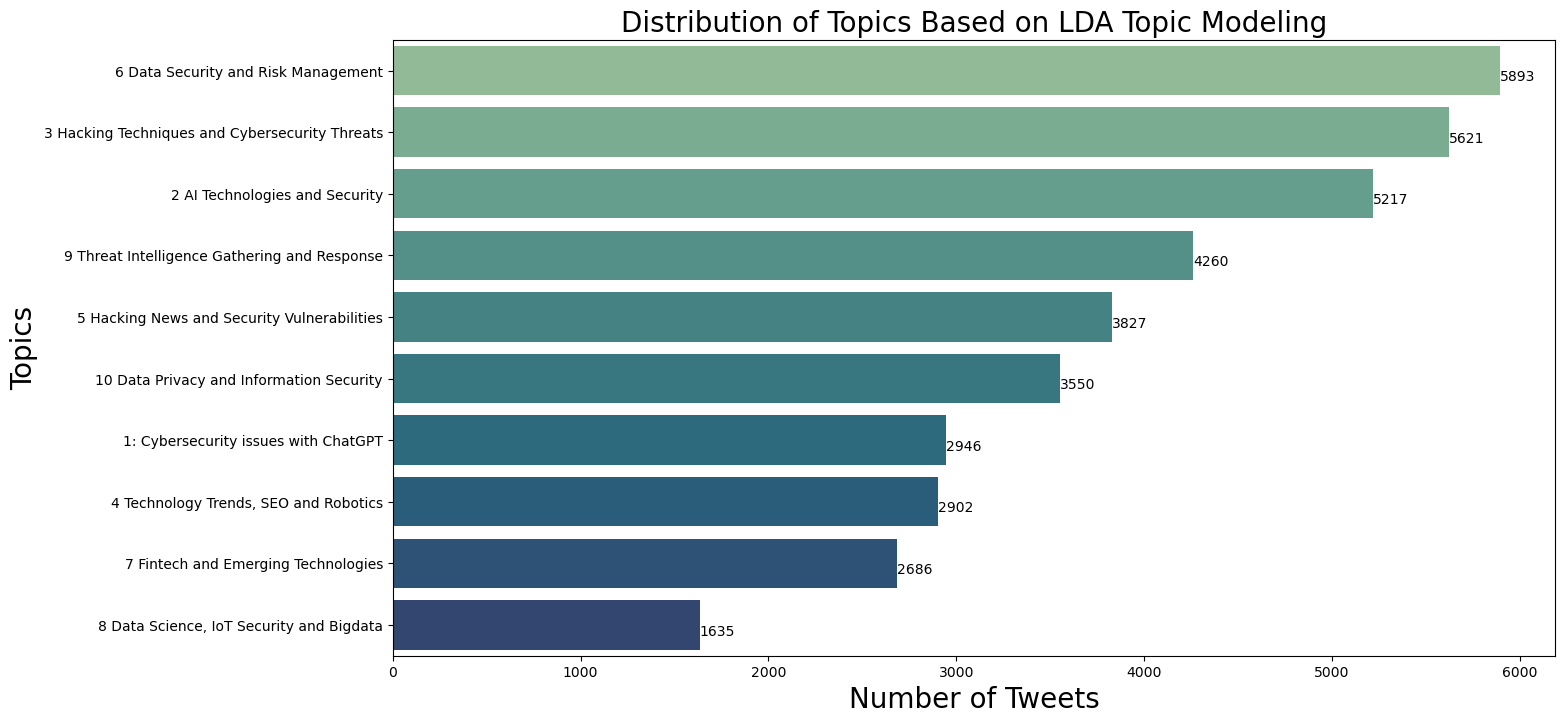

In [120]:
#plot a bar chart to show the number of tweets for each topic
sort_name = topic_df.sort_values('Tweet_count',ascending=False)['Topic_Name'].to_list()
fig,ax = plt.subplots(1,1,figsize=(15,8))
ax = sns.barplot(y=topic_df['Topic_Name'], x=topic_df['Tweet_count'], order=sort_name, palette='crest')
for i in ax.patches:
    ax.annotate(int(i.get_width()), (i.get_width(), i.get_y()+0.5), va='center')
ax.set_ylabel('Topics', size=20)
ax.set_xlabel('Number of Tweets', size=20)
ax.set_title('Distribution of Topics Based on LDA Topic Modeling', size=20)

plt.show()

/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  ori

/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/home/daniel/anaconda3/lib/python3.9/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/home/daniel/an

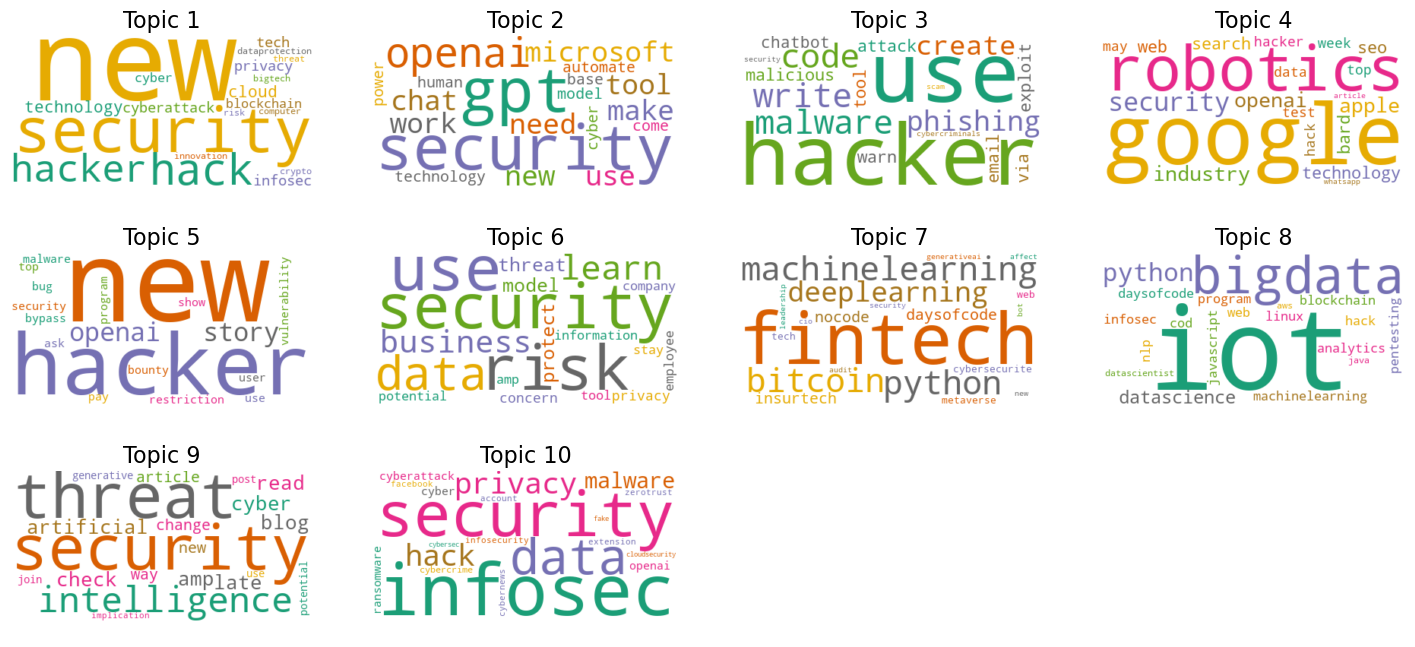

In [59]:
# word cloud
from wordcloud import WordCloud
wc = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=42)
fig, axs = plt.subplots(3,4, figsize=(18,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    if i<10:
        wc.generate(topic_df['Topic_Terms'][i])
        plt.subplot(3,4,i+1)
        plt.imshow(wc, interpolation="bilinear")
        plt.title(topic_df.index[i], size=16)
    plt.axis('off')

plt.show()

In [60]:
plt.savefig('wordcloud-topic.png', dpi=300)

<Figure size 640x480 with 0 Axes>

In [123]:
ada = pd.read_csv('Extracted_Twitter_topics.csv')

In [124]:
ada

,username,content,Final_Tokens,Datecreated,Dominant_Topic,Contribution%,Topic_Name
0,VeilleCyber3,Code-generating #AI can introduce #security #vulnerabilities \nhttps://t.co/tBoOQkK4LD\n\n#cryptocurrencies #MachineLearning #AI #Python #DeepLearning #100DaysOfCode #fintech #nocode #bitcoin #cybersecurity #cybersecurite #inSurTech #ChatGPT https://t.co/BOjNHVlNQ0,"['code', 'generate', 'introduce', 'security', 'vulnerability', 'machinelearning', 'python', 'deeplearning', 'daysofcode', 'fintech', 'nocode', 'bitcoin', 'cybersecurity', 'cybersecurite', 'insurtech', 'chatgpt']",2022-12-29,7,73.02,T7 ChatGPT Productivity in Coding
1,halllo,Advanced prompt engineering also needs some kind of #security #ChatGPT @SGgrc \nhttps://t.co/euF66Y2KXt,"['advanced', 'prompt', 'engineering', 'also', 'need', 'kind', 'security', 'chatgpt']",2022-12-29,2,61.37,T2 Ehancing Company data Security
2,MrMarchi,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/EYOMaiWkn5.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/LsbJxuSUm8,"['chatgpt', 'big', 'deal', 'digital', 'security', 'ainews', 'application', 'bug', 'chatbot', 'chatbots', 'code', 'cod', 'composition', 'computer', 'customerservice', 'cybersecurity']",2022-12-29,6,63.94,T6 Security Risks of ChatGPT usage
3,MrSkanner,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/1mLxQxpvAS.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding #Composition #Computers #CustomerService #CyberSecurity #CyberSecurityNews #Da ... https://t.co/vxhMiwJkPq,"['chatgpt', 'big', 'deal', 'digital', 'security', 'ainews', 'application', 'bug', 'chatbot', 'chatbots', 'code', 'cod', 'composition', 'computer', 'customerservice', 'cybersecurity']",2022-12-29,6,63.94,T6 Security Risks of ChatGPT usage
4,angelesgomez__,I’ve been down the chat GPT rabbit hole.. and I’m fucking scared I’m not making it out of college with any job security,"['chat', 'gpt', 'rabbit', 'hole', 'fuck', 'scar', 'make', 'college', 'job', 'security']",2022-12-28,2,54.64,T2 Ehancing Company data Security
...,...,...,...,...,...,...,...
38532,BubblyOrca,"Creating Solidity/Rust/Clarity or any contract-based lang smart contracts from ChatGPT poses huge security risks.\n\nAs a hacker, if I can reverse engineer a model and find the sources of the training data that ChatGPT aggregates. I can inject faulty code with vulns. #NotBullish","['create', 'solidity', 'rust', 'clarity', 'contract', 'base', 'lang', 'smart', 'contract', 'chatgpt', 'pose', 'huge', 'security', 'risk', 'hacker', 'reverse', 'engineer', 'model', 'find', 'source', 'train', 'data', 'chatgpt', 'aggregate', 'inject', 'faulty', 'code', 'vulns', 'notbullish']",2022-12-30,4,35.37,T4 Industrial Robotics Application
38533,GHO_STWebDesign,We just saw someone get a #rubberduckyscript off #chatgpt &amp; use it to unlock a phone in minutes. #cybersecurity #capetown #hackers #southafrica,"['saw', 'someone', 'get', 'chatgpt', 'amp', 'use', 'unlock', 'phone', 'minute', 'cybersecurity', 'capetown', 'hacker', 'southafrica']",2022-12-30,5,65.23,T5 Vulnerability and Bug hunting tool
38534,Hacker__News,Where does ChatGPT fall on the political compass?\n\n#compass #does #biases #political #models #chatgpt #quiz #answers #fall #responses #results #tests #trained\n\nhttps://t.co/2I9ZXlHuP2 https://t.co/IawEECbECU,"['chatgpt', 'fall', 'political', 'compass', 'compass', 'bias', 'political', 'model', 'chatgpt', 'quiz', 'answer', 'fall', 'response', 'result', 'test', 'train']",2022-12-30,6,57.72,T6 Security Risks of ChatGPT usage
38535,motakasoft,"GitHub Trending Archive, 28 Dec 2022, Go. ZeStream/zestream-server, bitindi/blockchain-core, ChatGPT-Hackers/ChatGPT-API-server, Edgenesis/shifu, yannh/kubeconform, go-sonic/sonic, HavocFramework/Havoc, jinzhu/copier, cas